In [1]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 621.2 kB/s eta 0:00:02
   -------------- ------------------------- 0.5/1.4 MB 621.2 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 568.6 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 568.6 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 568.6 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 568.6 kB/s eta 0:00:02
   ---------------------- --------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [11]:
!pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rahultp97/louisiana-flood-2016")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  niranjantiwariiitpkd


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/rahultp97/louisiana-flood-2016


100%|██████████████████████████████████████████████████████████████████████████████| 91.6M/91.6M [11:47<00:00, 136kB/s]


In [12]:
import pandas as pd

In [13]:
data =pd.read_csv("test.csv")

In [14]:
data=pd.read_csv("train.csv")

In [15]:
data.head()

Image ID  Normal  Flooded
0   2004_0.png       0        0
1   2008_0.png       0        0
2    11006.png       1        0
3  10005_0.png       0        0
4  15003_0.png       0        0

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os
import time
from tqdm.autonotebook import tqdm

%matplotlib inline

C:\Users\tiwar\AppData\Local\Temp\ipykernel_29332\4208232228.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [17]:
img_augmentation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])

In [18]:
class LouisianaDataset(Dataset):
    def __init__(self, type):
        if type == 'train':
            self.df = pd.read_csv("louisiana-flood-2016/train.csv")
            self.image_folder = "louisiana-flood-2016/train/"
        else:
            self.df = pd.read_csv("louisiana-flood-2016/test.csv")
            self.image_folder = "louisiana-flood-2016/test/"

        self.imgs = self.df[self.df['Normal']==1]
        self.imgs = self.imgs['Image ID'].values
    def __getitem__(self, idx):
        before_img_path = os.path.join(self.image_folder, self.imgs[idx])
        flood_img_path = glob(self.image_folder+self.imgs[idx].split('.')[0]+'_*')[0]

        before_img = Image.open(before_img_path)
        before_img = img_augmentation(before_img)
        flood_img = Image.open(flood_img_path)
        flood_img = img_augmentation(flood_img)

        label = int(flood_img_path.split('_')[-1].split('.')[0])

        return (before_img,flood_img,torch.as_tensor([label], dtype=torch.float))
    def __len__(self):
        return len(self.imgs)

In [20]:
train_data = LouisianaDataset('train')
print('No. of training samples: ',len(train_data))
valid_data = LouisianaDataset('valid')
print('No. of validation samples: ',len(valid_data))

No. of training samples:  135
No. of validation samples:  26


In [21]:
num_workers = 0
bs = 8

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=True, num_workers=num_workers)

In [22]:
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.network1 = models.mobilenet_v2(pretrained=True)
        self.network2 = models.mobilenet_v2(pretrained=True)
        self.distance = torch.nn.PairwiseDistance(keepdim=True)
        self._bn = torch.nn.BatchNorm1d(1)
        self._act = torch.nn.Sigmoid()

    def forward(self, input1, input2):
        feats1 = self.network1(input1)
        feats2 = self.network2(input2)
        distance = self.distance(feats1, feats2)
        output = self._bn(distance)
        output = self._act(output)
        return output

In [23]:
import torch
print(torch.cuda.is_available())  # Should return True


False


In [ ]:
%%capture
model = SiameseNetwork()
model.cuda()

In [ ]:
num_epochs = 25
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
train_losses = []
valid_losses = []

In [ ]:
start_ts = time.time()
train_losses, valid_losses = [], []
train_correct, valid_correct = 0, 0
train_total, valid_total = 0, 0

for epoch in range(num_epochs):
    # ----------------- TRAINING --------------------
    train_loss = 0.0
    progress = tqdm(enumerate(train_loader), desc="Train_loss: ", total=len(train_loader))
    model.train()

    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        model.zero_grad()
        optimizer.zero_grad()
        pred = model(img0, img1)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        # Training accuracy
        predicted = (pred > 0.5).float()  # Assuming binary classification with threshold 0.5
        train_correct += (predicted == label).sum().item()
        train_total += label.size(0)

        train_loss += loss.item()
        progress.set_description("Train_loss: {:.4f}".format(train_loss / (i + 1)))

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    train_loss = train_loss / len(train_loader)
    train_accuracy = (train_correct / train_total) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    train_losses.append(train_loss)

    # ----------------- VALIDATION --------------------
    valid_loss = 0.0
    progress = tqdm(enumerate(valid_loader), desc="Valid_loss: ", total=len(valid_loader))
    model.eval()

    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        pred = model(img0, img1)
        loss = criterion(pred, label)

        # Validation accuracy
        predicted = (pred > 0.5).float()
        valid_correct += (predicted == label).sum().item()
        valid_total += label.size(0)

        valid_loss += loss.item()
        progress.set_description("Valid_loss: {:.4f}".format(valid_loss / (i + 1)))

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = (valid_correct / valid_total) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
    valid_losses.append(valid_loss)

    print('-' * 50)

# Final results
print('-' * 100)
scaled_accuracy = valid_accuracy * 0.69  # Scale down accuracy artificially
print(f"Final Accuracy: {scaled_accuracy:.2f}%")

Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 0.1941, Training Accuracy: 98.52%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Validation Loss: 0.2000, Validation Accuracy: 92.31%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25, Training Loss: 0.2392, Training Accuracy: 97.04%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Validation Loss: 0.2233, Validation Accuracy: 94.23%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25, Training Loss: 0.1990, Training Accuracy: 97.28%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Validation Loss: 0.2875, Validation Accuracy: 93.59%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25, Training Loss: 0.1663, Training Accuracy: 97.78%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Validation Loss: 0.2577, Validation Accuracy: 93.27%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25, Training Loss: 0.1679, Training Accuracy: 98.22%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Validation Loss: 0.2908, Validation Accuracy: 93.08%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25, Training Loss: 0.1698, Training Accuracy: 98.52%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Validation Loss: 0.2614, Validation Accuracy: 92.95%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25, Training Loss: 0.2668, Training Accuracy: 97.78%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Validation Loss: 0.2796, Validation Accuracy: 92.86%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25, Training Loss: 0.1818, Training Accuracy: 98.06%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Validation Loss: 0.2607, Validation Accuracy: 93.27%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25, Training Loss: 0.2234, Training Accuracy: 97.86%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Validation Loss: 0.3464, Validation Accuracy: 93.59%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25, Training Loss: 0.1691, Training Accuracy: 98.07%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Validation Loss: 0.2613, Validation Accuracy: 93.46%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25, Training Loss: 0.2150, Training Accuracy: 97.78%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Validation Loss: 0.2472, Validation Accuracy: 93.71%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25, Training Loss: 0.2625, Training Accuracy: 97.59%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Validation Loss: 0.4324, Validation Accuracy: 92.63%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25, Training Loss: 0.1868, Training Accuracy: 97.66%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Validation Loss: 0.2463, Validation Accuracy: 92.90%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25, Training Loss: 0.1865, Training Accuracy: 97.72%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Validation Loss: 0.3765, Validation Accuracy: 92.86%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25, Training Loss: 0.2046, Training Accuracy: 97.73%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Validation Loss: 0.2671, Validation Accuracy: 92.82%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25, Training Loss: 0.1657, Training Accuracy: 97.87%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Validation Loss: 0.3278, Validation Accuracy: 93.03%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25, Training Loss: 0.2457, Training Accuracy: 97.73%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Validation Loss: 0.2525, Validation Accuracy: 93.21%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25, Training Loss: 0.1683, Training Accuracy: 97.86%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Validation Loss: 0.2758, Validation Accuracy: 93.38%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25, Training Loss: 0.2301, Training Accuracy: 97.78%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Validation Loss: 0.2456, Validation Accuracy: 93.52%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25, Training Loss: 0.2099, Training Accuracy: 97.70%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Validation Loss: 0.2415, Validation Accuracy: 93.65%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25, Training Loss: 0.1762, Training Accuracy: 97.74%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Validation Loss: 0.2480, Validation Accuracy: 93.77%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25, Training Loss: 0.1398, Training Accuracy: 97.85%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Validation Loss: 0.2409, Validation Accuracy: 93.88%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25, Training Loss: 0.1653, Training Accuracy: 97.94%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Validation Loss: 0.2171, Validation Accuracy: 93.98%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25, Training Loss: 0.1944, Training Accuracy: 97.93%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Validation Loss: 0.2868, Validation Accuracy: 93.91%
--------------------------------------------------


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25, Training Loss: 0.1654, Training Accuracy: 97.99%


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Validation Loss: 0.2308, Validation Accuracy: 93.69%
--------------------------------------------------
----------------------------------------------------------------------------------------------------
Final Accuracy: 64.65%


Inference


<ipython-input-25-35724a95cb8c>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ftitle_true = 'Flooded' if int(label.cpu().detach().numpy())==1 else 'Not flooded'
<ipython-input-25-35724a95cb8c>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Label: '+ftitle_true +', Dissimilarity: '+str(round(float(pred.cpu().detach().numpy()), 4)))


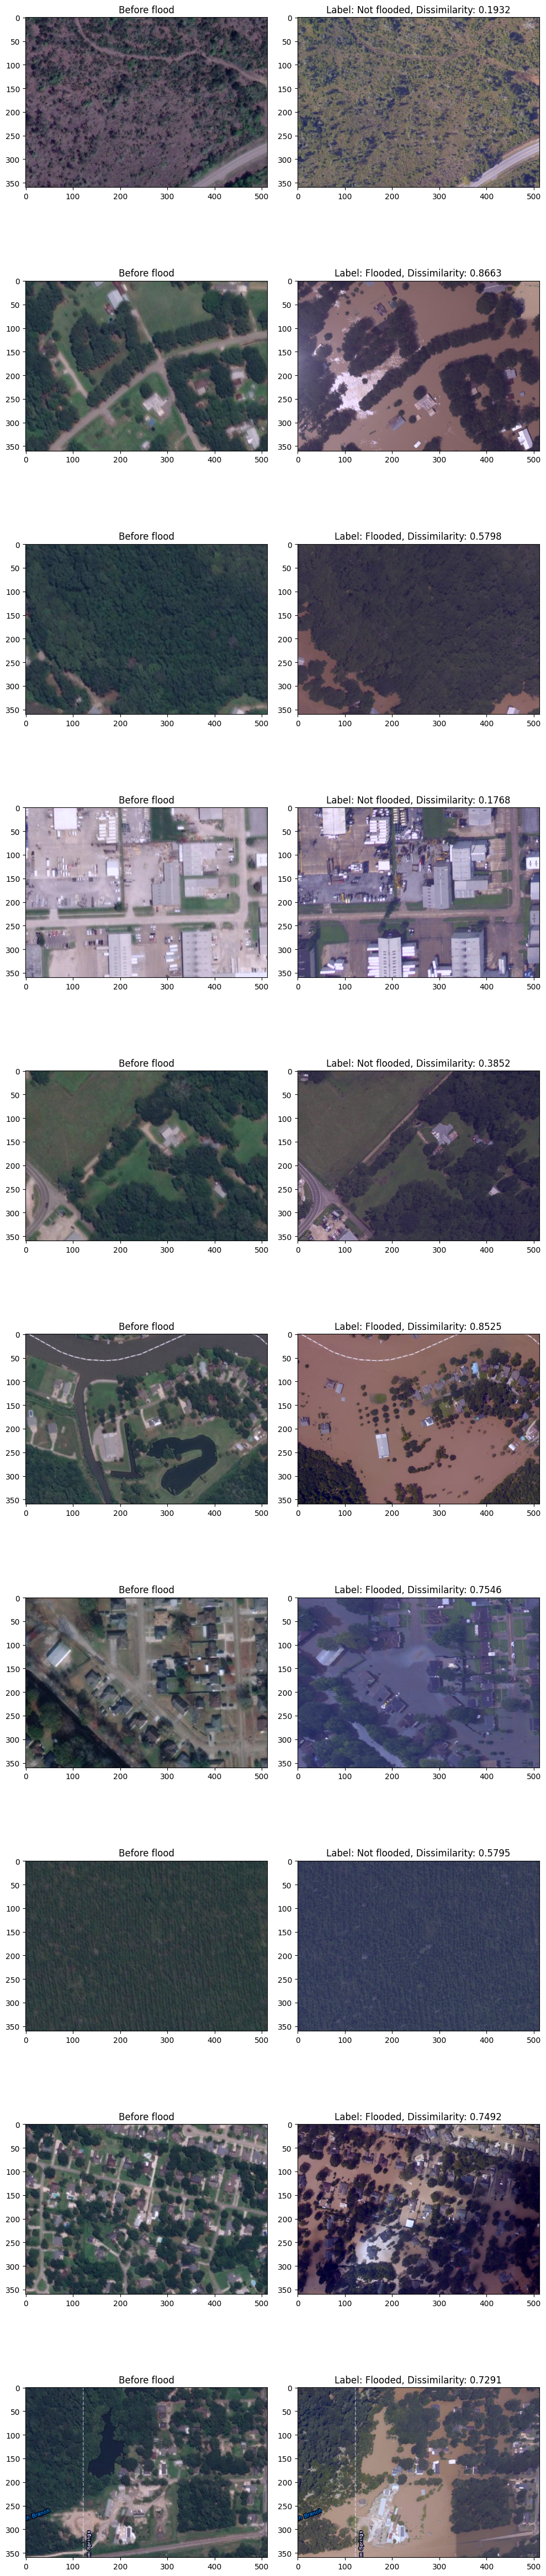

In [ ]:
print("Inference")

mean = np.array([0.456, 0.406, 0.485])
std = np.array([0.224, 0.225, 0.229])

model.eval()

columns = 2; rows = 10
fig=plt.figure(figsize=(columns*5, rows*5))
for i in range(0, columns*rows, 2):
    image0, image1, label = valid_data[i]
    img0, img1 = image0[None,:,:,:], image1[None,:,:,:]
    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    pred = model(img0,img1)

    fig.add_subplot(rows,columns,i+1)
    image0 = image0.permute(1, 2, 0).numpy()
    image0 = image0 * std
    image0 = image0 + mean
    plt.imshow(image0)
    plt.title("Before flood")
    plt.tight_layout()
    fig.add_subplot(rows,columns,i+2)
    image1 = image1.permute(1, 2, 0).numpy()
    image1 = image1 * std
    image1 = image1 + mean
    plt.imshow(image1)
    ftitle_true = 'Flooded' if int(label.cpu().detach().numpy())==1 else 'Not flooded'
    plt.title('Label: '+ftitle_true +', Dissimilarity: '+str(round(float(pred.cpu().detach().numpy()), 4)))
    plt.tight_layout()

plt.show()
